## Visualize global admin0 and country level admin1 results

In this notebook we quickly plot the some resulting maps from the model putput for global admin0 results and country-level admin1 results.

Shapefiles for the counrty/admin1 borders can be accessed here: https://gadm.org/download_country.html
Shapefiles for global admin0 borders can be accessed here: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/ or here: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/

In [1]:
# load libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize
from cartopy import crs as ccrs
import seaborn as sns
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# paths (to be adjusted when running on different machines)
results_path = '/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/data/results/'
shp_path = '/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/data/shapefiles/'
fig_save_path = '/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/data/results/plots/'

# projection for plotting
robinson = ccrs.Robinson().proj4_init

## Admin0

In [3]:
def plot_global_cf_admin0(csv_file, year, RCP, metric):
    """
    Plot a global map of admin0 results.
    
    Args:
    - csv_file: Path to the CSV file containing results.
    - year: Time period to filter (e.g., 2020, 2050, 2100).
    - RCP: Scenario to filter (e.g., optimistic, pessimistic, medium).
    - metric: Metric to plot (e.g., 'aed', 'pmd_10_med').
    """
    # Load the results data
    df = pd.read_csv(csv_file)
    
    # Filter the data based on year and RCP
    df_filtered = df[(df['time_horizon'] == year) & (df['scenario'] == RCP)]
    
    # Load the world shapefile
    world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
    
    world = world[world['ISO_A3'] != 'ATA']
    
    # Merge with the filtered results based on the ISO-3 country code
    world = world.merge(df_filtered, left_on='ISO_A3', right_on='iso', how='left')
    
    # Ensure the metric is treated as continuous
    world[metric] = pd.to_numeric(world[metric], errors='coerce')
    
    # Reproject the world shapefile to Robinson projection
    world = world.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Plot the boundaries first (outlines)
    world.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    # Get the maximum value for the metric column
    vmax_value = world[metric].max()
    
    # Plot the filled polygons with the data (after the borders are drawn)
    world.plot(column=metric, ax=ax, legend=True, cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1, vmax=vmax_value),
                                  edgecolor='black', linewidth=0.1)
    
    # Set the title
    #ax.set_title(f'Displaced people from coastal floods ({metric} - RCP{RCP} - {year})', fontsize=16)
    
    # Remove axis
    ax.set_axis_off()
    
    # Save plot
    #plt.savefig(fig_save_path+f'displacement_CF_global_{year}_{RCP}_{metric}.png', transparent=True)


def plot_global_tc_admin0(csv_file, period, scenario, metric):
    """
    Plot a global map of admin0 results.
    
    Args:
    - csv_file: Path to the CSV file containing results.
    - period: Time period to filter (e.g., 'hist', '2050').
    - scenario: Scenario to filter (e.g., 'ERA-5', 'ssp245').
    - metric: Metric to plot (e.g., 'AAD', 'RP_10').
    """
    # Load the results data
    df = pd.read_csv(csv_file)
    
    # Filter the data based on period and scenario
    df_filtered = df[(df['Period'] == period) & (df['Scenario'] == scenario)]
    
    # Load the world shapefile
    world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
    
    world = world[world['ISO_A3'] != 'ATA']
    
    # Merge with the filtered results based on the ISO-3 country code
    world = world.merge(df_filtered, left_on='ISO_A3', right_on='iso3', how='left')
    
    # Ensure the metric is treated as continuous
    world[metric] = pd.to_numeric(world[metric], errors='coerce')
    
    # Reproject the world shapefile to Robinson projection
    world = world.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Plot the boundaries first (outlines)
    world.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    # Get the maximum value for the metric column
    vmax_value = world[metric].max()
    
    # Plot the filled polygons with the data (after the borders are drawn)
    world.plot(column=metric, ax=ax, legend=True, cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1, vmax=vmax_value),
                                  edgecolor='black', linewidth=0.1)
    
    # Set the title
    #ax.set_title(f'Displaced people from tropical cyclones ({metric} - {scenario} - {period})', fontsize=16)
    
    # Remove axis
    ax.set_axis_off()
    
    # Save plot
    #plt.savefig(fig_save_path+f'displacement_TC_global_{period}_{scenario}_{metric}.png', transparent=True)


### Plots global present-day results

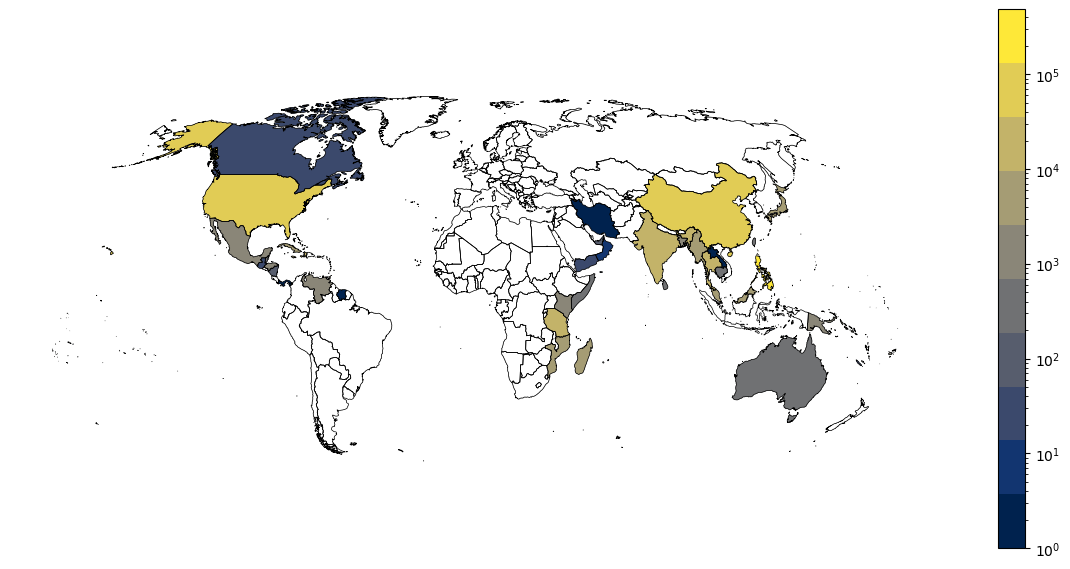

In [4]:
plot_global_tc_admin0(f'{results_path}displacement_risk_tc_global_admin0_0.3_check.csv', 'hist', 'ERA-5', 'AAD')

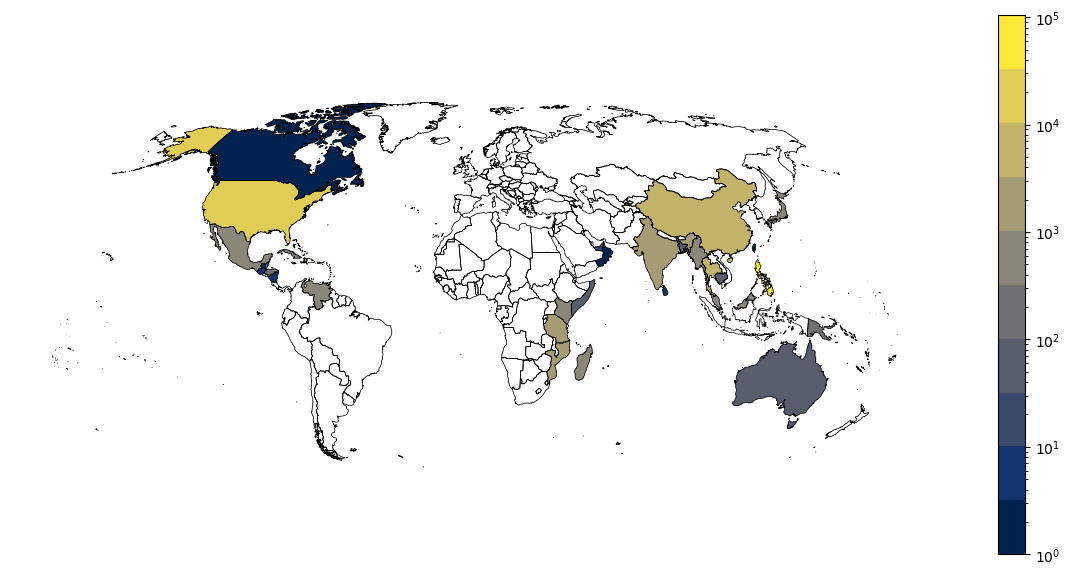

In [5]:
plot_global_tc_admin0(f'{results_path}displacement_risk_tc_global_admin0_0.55_check.csv', 'hist', 'ERA-5', 'AAD')

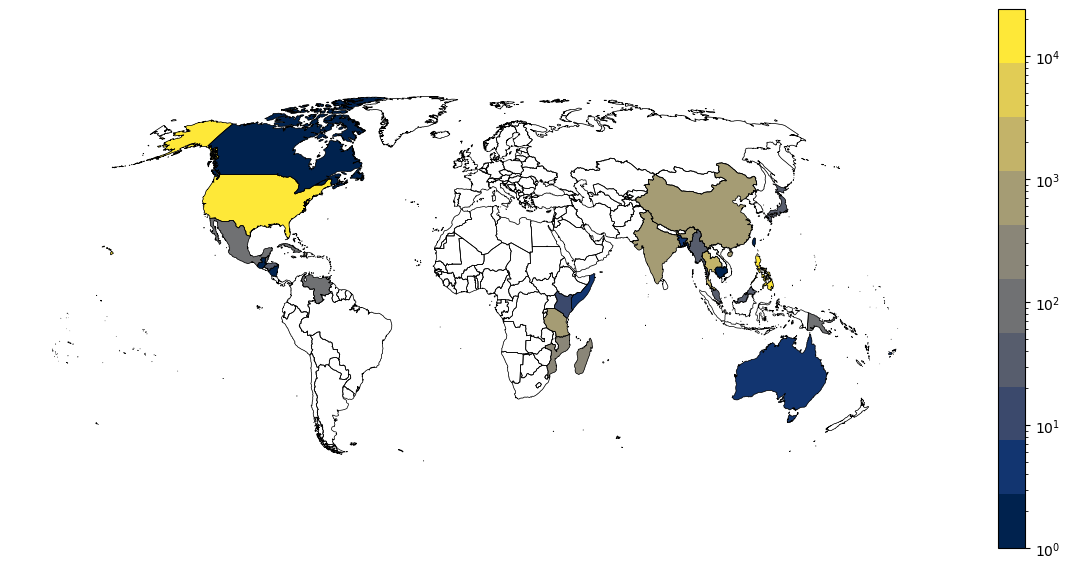

In [6]:
plot_global_tc_admin0(f'{results_path}displacement_risk_tc_global_admin0_0.7_check.csv', 'hist', 'ERA-5', 'AAD')

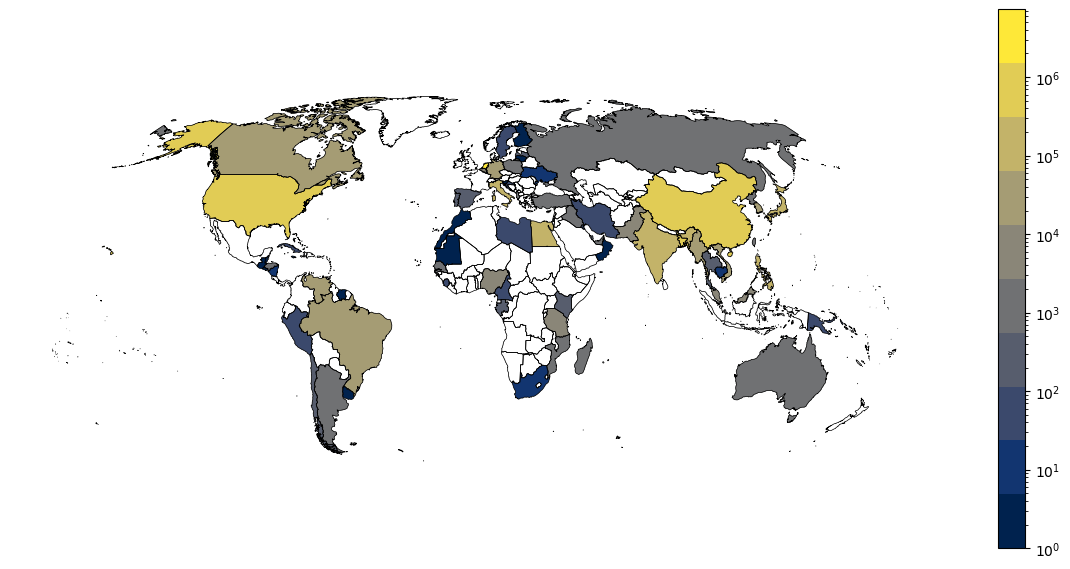

In [7]:
plot_global_cf_admin0(f'{results_path}displacement_risk_cf_global_admin0_consolidated.csv', 2020, 'medium', 'aed_med')

### Calculate relative change in future displacement

In [8]:
def calculate_relative_change_tc(df, period, scenario):
    """Calculate relative change for Tropical Cyclones."""
    
    period = str(period)
    # Base and future gdfs with corrected Period filtering
    base_gdf = df[(df['Period'] == 'hist')]
    fut_gdf = df[(df['Period'] == period) & (df['Scenario'] == scenario)]

    print(f"Base GDF size: {base_gdf.shape}")
    print(f"Future GDF size: {fut_gdf.shape}")

    # Ensure indexes match before performing operations
    fut_gdf = fut_gdf.set_index('iso3')
    base_gdf = base_gdf.set_index('iso3')

    # Select only numeric columns for the relative change calculation
    numeric_cols = base_gdf.select_dtypes(include=[np.number]).columns
    
    # Relative change calculation, handling division by zero and NaN
    rel_change_gdf = (fut_gdf[numeric_cols] - base_gdf[numeric_cols]) / base_gdf[numeric_cols]
    rel_change_gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    rel_change_gdf.fillna(0, inplace=True)  # Replace NaN values with 0
    rel_change_gdf.reset_index(inplace=True)
    
    return rel_change_gdf


def calculate_relative_change_cf(df, year, RCP):
    """Calculate relative change for Coastal Flooding."""
    # Base and future gdfs
    base_gdf = df[(df['time_horizon'] == 2020) & (df['scenario'] == RCP)]
    fut_gdf = df[(df['time_horizon'] == year) & (df['scenario'] == RCP)]
    
    print(f"Base GDF size: {base_gdf.shape}")
    print(f"Future GDF size: {fut_gdf.shape}")
    
    # Ensure indexes match before performing operations
    fut_gdf = fut_gdf.set_index('iso')
    base_gdf = base_gdf.set_index('iso')

    # Select only numeric columns for the relative change calculation
    numeric_cols = base_gdf.select_dtypes(include=[np.number]).columns
    
    # Relative change calculation, handling division by zero and NaN
    rel_change_gdf = (fut_gdf[numeric_cols] - base_gdf[numeric_cols]) / base_gdf[numeric_cols]
    rel_change_gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    rel_change_gdf.fillna(0, inplace=True)  # Replace NaN values with 0
    rel_change_gdf.reset_index(inplace=True)
    
    return rel_change_gdf

In [9]:
def plot_global_change_cf_admin0(csv_file, year, RCP, metric):
    """
    Plot a global map of admin0 relative change results for Coastal Flooding (CF).
    
    Args:
    - csv_file: Path to the CSV file containing results.
    - year: Time period to filter (e.g., 2020, 2050, 2100).
    - RCP: Scenario to filter (e.g., optimistic, pessimistic, medium).
    - metric: Metric to plot (e.g., 'aed', 'pmd_10_med').
    """
    # Load the results data
    df = pd.read_csv(csv_file)
    
    # Calculate relative change gdf
    df_rel_change = calculate_relative_change_cf(df, year, RCP)
    
    # Load the world shapefile
    world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
    world = world[world['ISO_A3'] != 'ATA']
    
    # Merge with the relative change results based on the ISO-3 country code
    world = world.merge(df_rel_change, left_on='ISO_A3', right_on='iso', how='left')
    
    # Ensure the metric is treated as continuous
    world[metric] = pd.to_numeric(world[metric], errors='coerce')
    
    # Reproject the world shapefile to Robinson projection
    world = world.to_crs(robinson)

    fontsize = 14
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Plot the boundaries first (outlines)
    world.boundary.plot(ax=ax, color='black', linewidth=0.5)
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('Purples', 10)
    
    # Handle vmin and vmax values safely
    vmin_value = world[metric].min()
    vmax_value = world[metric].max()
    
    # Check if vmin or vmax are invalid (NaN or too close to each other)
    if np.isnan(vmin_value) or np.isnan(vmax_value) or vmin_value == vmax_value:
        vmin_value = -100
        vmax_value = 100

    # Use SymLogNorm for handling both positive and negative values with a logarithmic scale
    norm = SymLogNorm(linthresh=1, linscale=1, vmin=vmin_value, vmax=vmax_value)

    # Plot the filled polygons with the data (after the borders are drawn)
    world.plot(column=metric, ax=ax, legend=True, cmap=cmap, norm=norm,
                                  edgecolor='black', linewidth=0.1)
    
    # Set the title
    #ax.set_title(f'Relative Change in {metric} (%) - Year {year} - Scenario {RCP}', fontsize=16)

    # Remove axis
    ax.set_axis_off()
    
    # Save plot
    #plt.savefig(fig_save_path+f'displacement_CF_global_{year}_{RCP}_{metric}_rel_change.png', transparent=True)

from matplotlib.colors import SymLogNorm

def plot_global_change_tc_admin0(csv_file, period, scenario, metric):
    """
    Plot a global map of admin0 relative change results for Tropical Cyclones (TC) in percentages using a symmetric logarithmic scale.
    """
    # Load the results data
    df = pd.read_csv(csv_file)
    
    # Calculate relative change gdf
    df_rel_change = calculate_relative_change_tc(df, period, scenario)
    
    # Convert relative change to percentage
    df_rel_change[metric] = df_rel_change[metric] * 100
    
    # Load the world shapefile
    world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
    world = world[world['ISO_A3'] != 'ATA']
    
    # Merge with the relative change results based on the ISO-3 country code
    world = world.merge(df_rel_change, left_on='ISO_A3', right_on='iso3', how='left')
    
    # Ensure the metric is treated as continuous and convert to percentage
    world[metric] = pd.to_numeric(world[metric], errors='coerce')
    
    # Remove invalid data (NaNs and Infs)
    world[metric].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Reproject the world shapefile to Robinson projection
    world = world.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Plot the boundaries first (outlines)
    world.boundary.plot(ax=ax, color='black', linewidth=0.5)
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('Purples', 10)
    
    # Handle vmin and vmax values safely
    vmin_value = world[metric].min()
    vmax_value = world[metric].max()
    
    # Check if vmin or vmax are invalid (NaN or too close to each other)
    if np.isnan(vmin_value) or np.isnan(vmax_value) or vmin_value == vmax_value:
        vmin_value = -100
        vmax_value = 100

    # Use SymLogNorm for handling both positive and negative values with a logarithmic scale
    norm = SymLogNorm(linthresh=1, linscale=1, vmin=vmin_value, vmax=vmax_value)

    # Plot the filled polygons with the data (after the borders are drawn)
    world.plot(column=metric, ax=ax, legend=True, cmap=cmap, norm=norm,
                                  edgecolor='black', linewidth=0.1)
    
    # Set the title
    #ax.set_title(f'Relative Change in {metric} (%) - Period {period} - Scenario {scenario}', fontsize=16)

    # Remove axis
    ax.set_axis_off()

    # Save plot
    #plt.savefig(fig_save_path+f'displacement_TC_global_{period}_{scenario}_{metric}_rel_change.png', transparent=True)

Base GDF size: (153, 9)
Future GDF size: (151, 9)


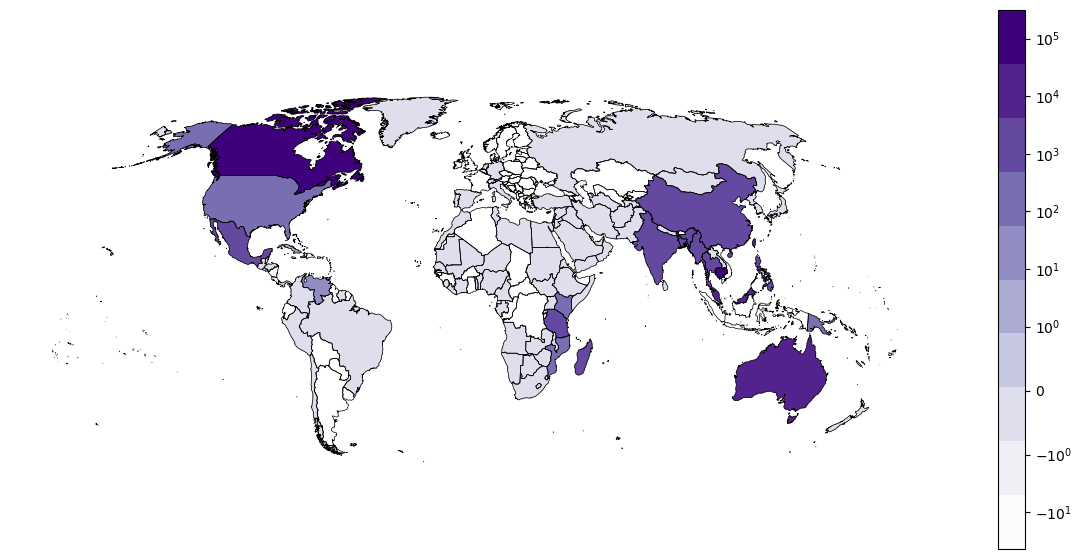

In [10]:
plot_global_change_tc_admin0(f'{results_path}displacement_risk_tc_global_admin0_0.7_check.csv', 2100, 'ssp245', 'AAD')

Base GDF size: (212, 12)
Future GDF size: (212, 12)


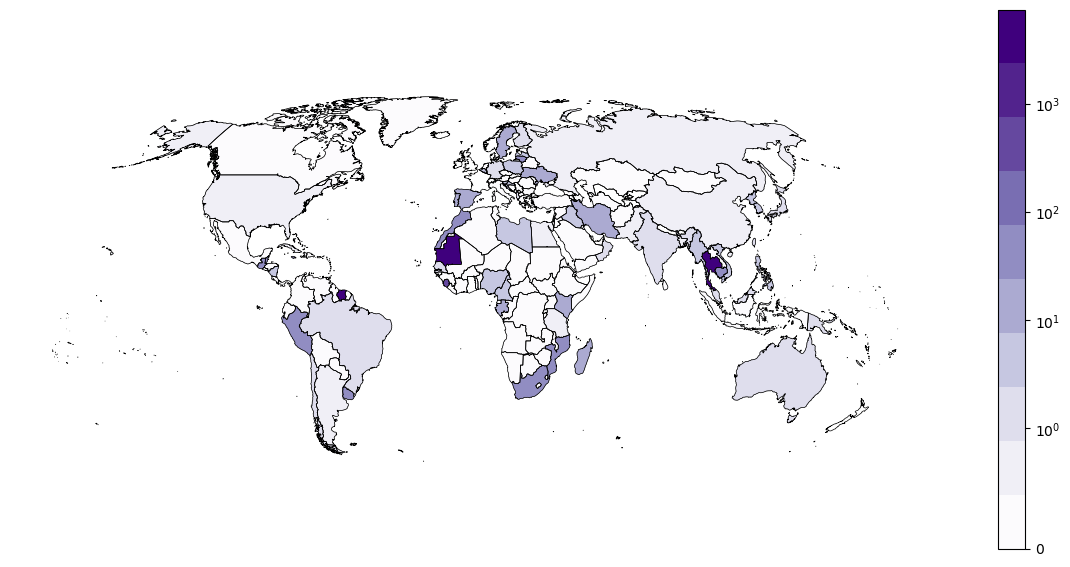

In [11]:
plot_global_change_cf_admin0(f'{results_path}displacement_risk_cf_global_admin0_consolidated.csv', 2100, 'optimistic', 'aed_med')

#### Aggretated admin0 values from admin1 files

In [12]:
def plot_admin0_values(csv_file, scenario, year, thresh, metric):
    """
    Plot regional values for the given country, scenario, year, threshold, and metric.
    
    Args:
    - csv_file: Path to the CSV file containing the data.
    - scenario: Scenario string ['optimistic', 'medium', 'pessimistic', 'current'].
    - year: Year ['hist', 2050, 2100] (filtered by column "time_horizon").
    - thresh: Threshold level ['low', 'med', 'high'].
    - metric: Metric type ['AAD', 'PMD_10', 'PMD_25', 'PMD_50', 'PMD_100', 'PMD_250'].
    
    Returns:
    - A plot showing the admin1 regional values for the selected country and scenario.
    """
    # Load CSV file into pandas DataFrame
    df = pd.read_csv(csv_file)
    
    df_clean = df[df['GID_1'].notna()]
    
    # Filter data based on scenario and year
    df_filtered = df[(df['scenario'] == scenario) & (df['time_horizon'] == year)]
    
    # Create the column name based on metric and threshold
    metric_column = f'{metric}_{thresh}'
    
    # Extract ISO-3 codes by taking the first three characters of 'GID_1'
    df_filtered['ISO3'] = df_filtered['GID_1'].str[:3]
    
    # Group by ISO-3 code and sum the admin1 values for the given metric_thresh
    df_aggregated = df_filtered.groupby('ISO3')[metric_column].sum().reset_index()

    # Create the column name based on metric and threshold
    metric_column = f'{metric}_{thresh}'

    # Load the world admin0 shapefile
    world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
    
    # Remove Antarctica from the shapefile
    world = world[world['ISO_A3'] != 'ATA']
    
    # Merge the aggregated data with the world shapefile on ISO-3 country codes
    world = world.merge(df_aggregated, left_on='ISO_A3', right_on='ISO3', how='left')

    
    world = world.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(15, 7))
    world.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    vmax_value = world[metric_column].max()
    # Plot the filtered geodataframe
    world.plot(column=metric_column, ax=ax, legend=True, cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1, vmax=vmax_value),
                                  edgecolor='black', linewidth=0.1) 
    
    # Add title and remove axes
    #ax.set_title(f'Displaced people ({metric} - {scenario} - {year} - {thresh})', fontsize=fontsize)
    sns.despine(left=True, bottom=True)
    ax.set_axis_off()
    
    # Save plot
    #plt.savefig(fig_save_path+f'displacement_global_{scenario}_{year}_{metric}.png', transparent=True)

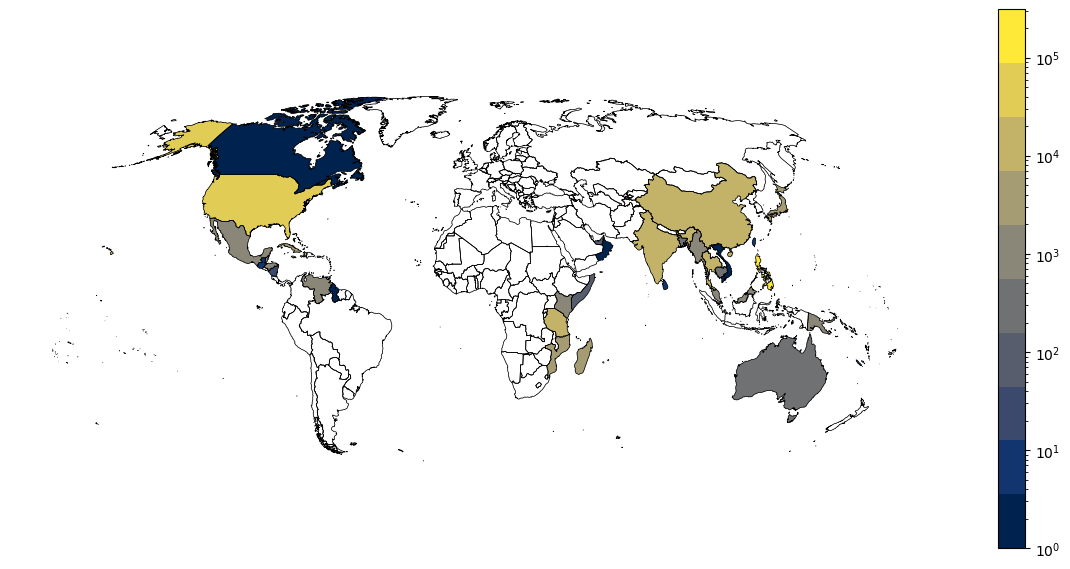

In [13]:
plot_admin0_values(f'{results_path}/displacement_risk_tc_global_admin1_check.csv', 'current', 'hist', 'medium', 'AAD')

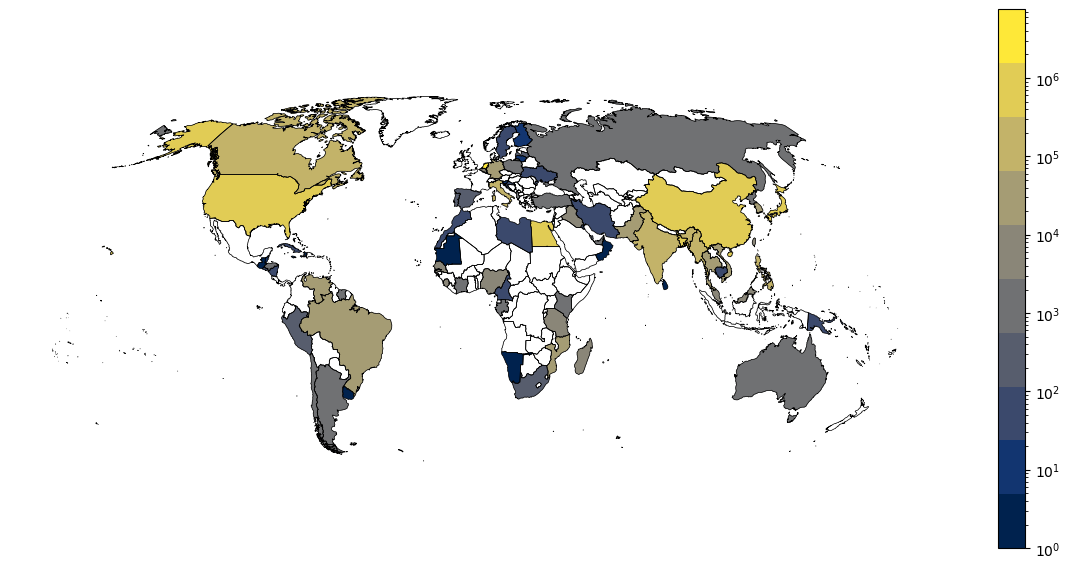

In [14]:
plot_admin0_values(f'{results_path}/displacement_risk_cf_global_admin1_consolidated.csv', 'medium', 2050, 'med', 'aed')

## Admin1

In [15]:
def plot_admin1_values(csv_file, country, scenario, year, thresh, metric):
    """
    Plot regional values for the given country, scenario, year, threshold, and metric.
    
    Args:
    - csv_file: Path to the CSV file containing the data.
    - country: 3-digit ISO country code (e.g., 'USA').
    - scenario: Scenario string ['optimistic', 'medium', 'pessimistic', 'current'].
    - year: Year ['hist', 2050, 2100] (filtered by column "time_horizon").
    - thresh: Threshold level ['low', 'med', 'high'].
    - metric: Metric type ['AAD', 'PMD_10', 'PMD_25', 'PMD_50', 'PMD_100', 'PMD_250'].
    
    Returns:
    - A plot showing the admin1 regional values for the selected country and scenario.
    """
    # Load CSV file into pandas DataFrame
    df = pd.read_csv(csv_file)
    
    df_clean = df[df['GID_1'].notna()]
    
    # Filter data based on input criteria
    df_filtered = df_clean[(df_clean['GID_1'].str.startswith(country)) & 
                     (df_clean['scenario'] == scenario) & 
                     (df_clean['time_horizon'] == year)]

    # Create the column name based on metric and threshold
    metric_column = f'{metric}_{thresh}'
    
    # Load shapefile
    gdf = gpd.read_file(f'{shp_path}/gadm41_{country}_shp/gadm41_{country}_1.shp')
    
    gdf = gdf[~gdf['GID_1'].str.contains('USA.2_')]
    # Merge it with filtered data
    gdf = gdf.merge(df_filtered, left_on='GID_1', right_on='GID_1', how='left')
    
    gdf = gdf.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    vmax_value = gdf[metric_column].max()
    # Plot the filtered geodataframe
    gdf.plot(column=metric_column, ax=ax, legend=True, cmap=cmap, vmax=vmax_value,
                                  edgecolor='black', linewidth=0.1)
    
    # Add title and remove axes
    ax.set_title(f'Displaced people ({metric} - {scenario} - {year} - {thresh})', fontsize=fontsize)
    sns.despine(left=True, bottom=True)
    ax.set_axis_off()
    
    # Save plot
    #plt.savefig(f'{country}_{year}_{scenario}_{metric_column}.png', transparent=True)

### TC results

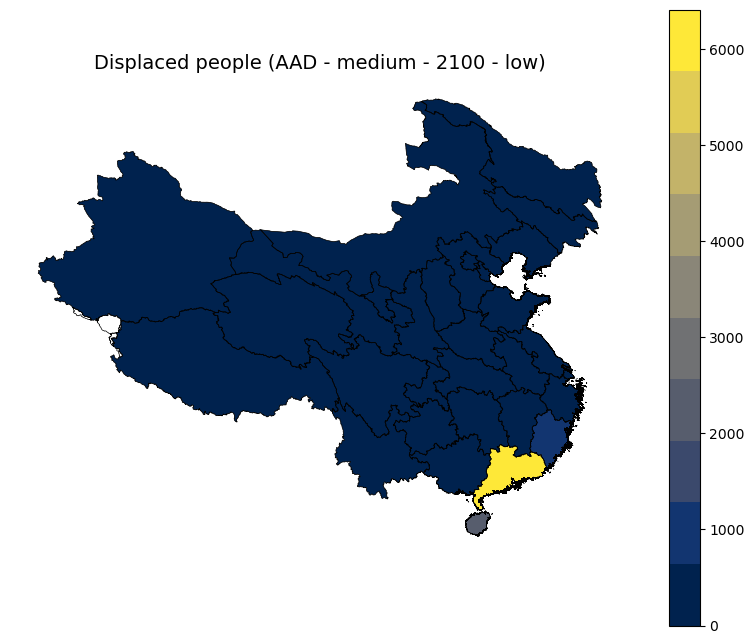

In [16]:
# Example usage (new):
plot_admin1_values(f'{results_path}/displacement_risk_tc_global_admin1_check.csv', 'CHN', 'medium', '2100', 'low', 'AAD')

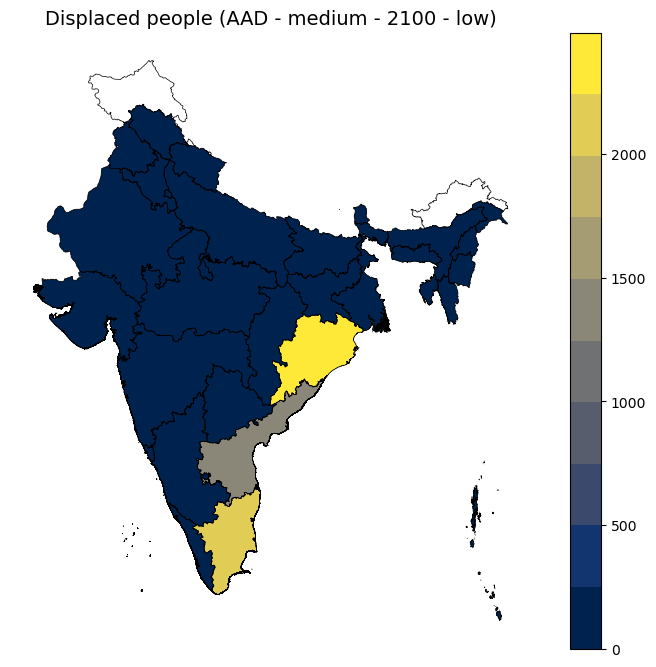

In [17]:
plot_admin1_values(f'{results_path}/displacement_risk_tc_global_admin1_check.csv', 'IND', 'medium', '2100', 'low', 'AAD')

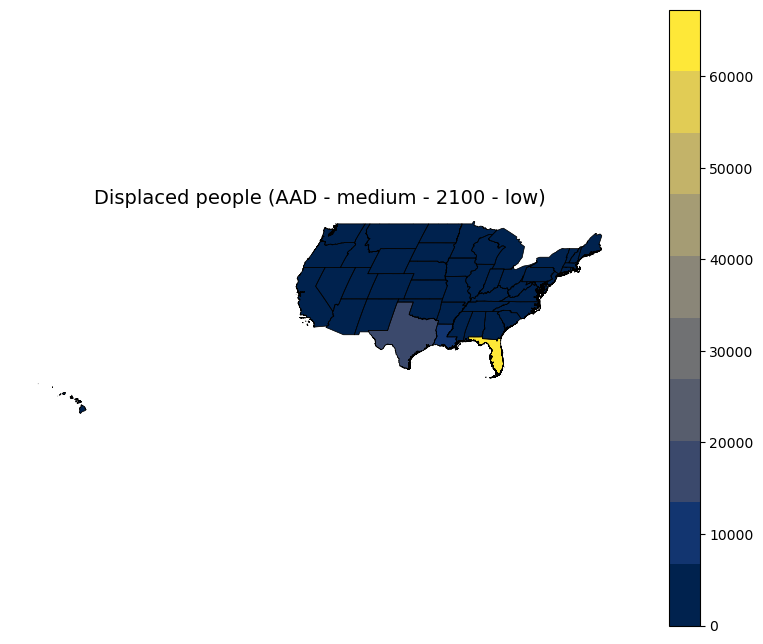

In [18]:
plot_admin1_values(f'{results_path}/displacement_risk_tc_global_admin1_check.csv', 'USA', 'medium', '2100', 'low', 'AAD')

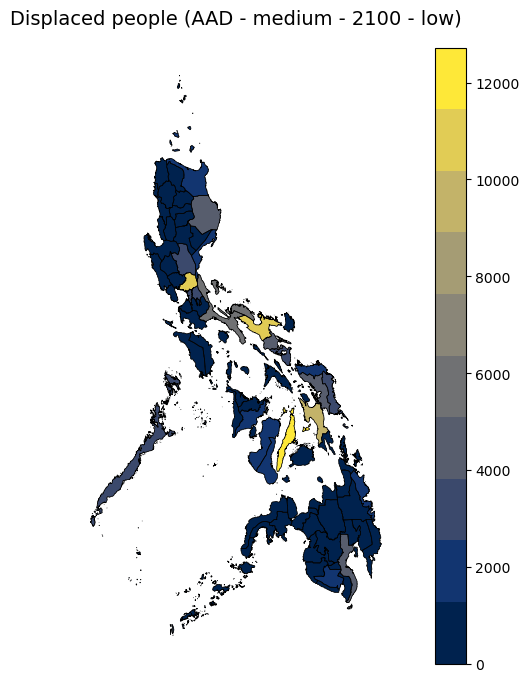

In [19]:
plot_admin1_values(f'{results_path}/displacement_risk_tc_global_admin1_check.csv', 'PHL', 'medium', '2100', 'low', 'AAD')

### Coastal flood results

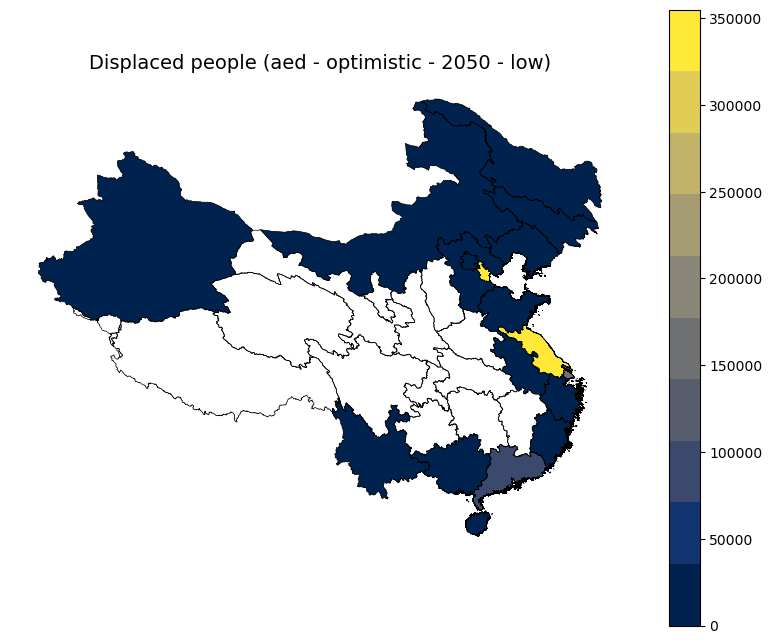

In [20]:
# Example usage:
plot_admin1_values(f'{results_path}displacement_risk_cf_global_admin1_consolidated.csv', 'CHN', 'optimistic', 2050, 'low', 'aed')

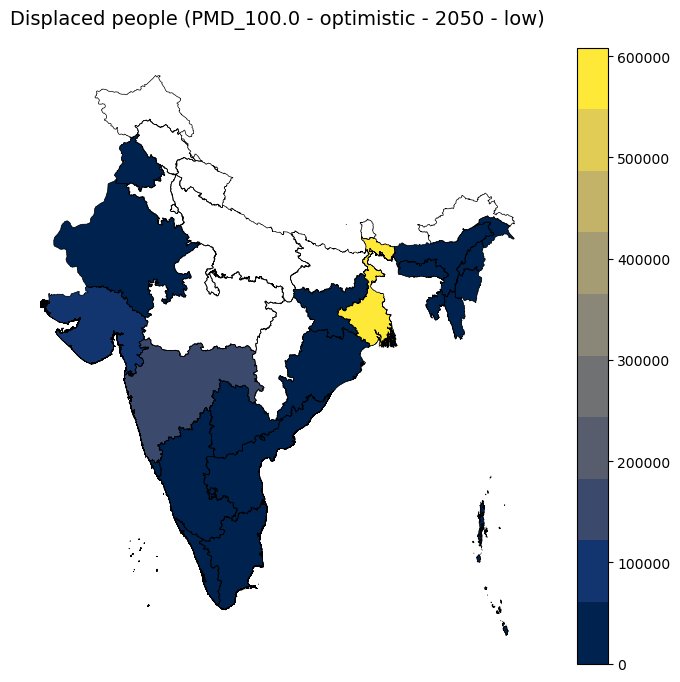

In [21]:
plot_admin1_values(f'{results_path}displacement_risk_cf_global_admin1_consolidated.csv', 'IND', 'optimistic', 2050, 'low', 'PMD_100.0')

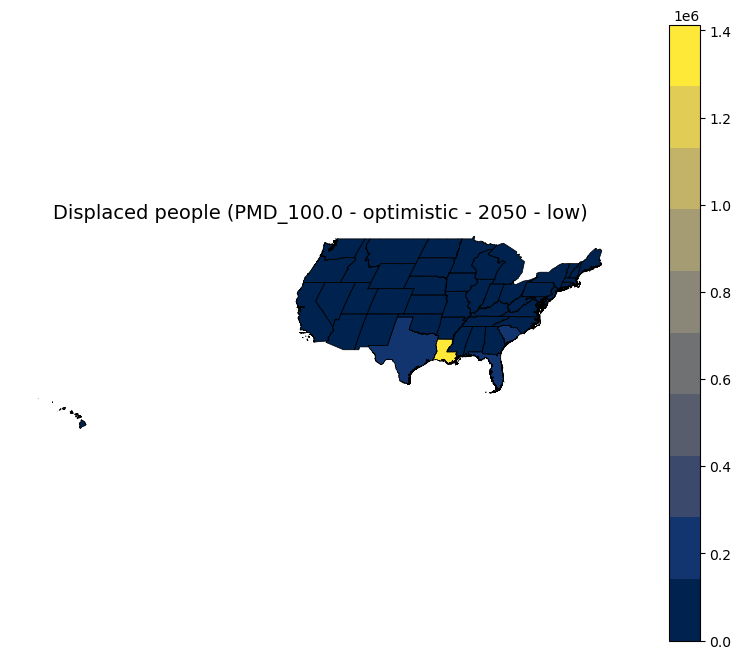

In [22]:
plot_admin1_values(f'{results_path}/displacement_risk_cf_global_admin1_consolidated.csv', 'USA', 'optimistic', 2050, 'low', 'PMD_100.0')